# Cumulated Graph of the Distance traveled:

This script provides the figure for cumulated water point. (note that you need to build the event "Water Stop" to get this graph)

*Warning: we set the waterpoint at the bottom right of the cage. If you use another location, change the code of the rebuildWaterPoint.py file.*

| ![](../images/cumulatedwaterpoint1.jpg) ![](../images/cumulatedwaterpoint2.jpg) ![](../images/cumulatedwaterpoint3.jpg) ![](../images/cumulatedwaterpoint4.jpg)
|:--:| 
|Example of cumulated water point|

Code launched.


Start :  0


Entry (in frame) : 0


End :  1296000


Entry (in frame) : 1296000
There will be 72 bins of 10min (18000frames) in the graph
The timebinList is: [0, 18000, 36000, 54000, 72000, 90000, 108000, 126000, 144000, 162000, 180000, 198000, 216000, 234000, 252000, 270000, 288000, 306000, 324000, 342000, 360000, 378000, 396000, 414000, 432000, 450000, 468000, 486000, 504000, 522000, 540000, 558000, 576000, 594000, 612000, 630000, 648000, 666000, 684000, 702000, 720000, 738000, 756000, 774000, 792000, 810000, 828000, 846000, 864000, 882000, 900000, 918000, 936000, 954000, 972000, 990000, 1008000, 1026000, 1044000, 1062000, 1080000, 1098000, 1116000, 1134000, 1152000, 1170000, 1188000, 1206000, 1224000, 1242000, 1260000, 1278000, 1296000] 

 with a length of 73.

 This script will plot the totalDistance traveled by the mice in the selected database... 

D:/LMT data/LMT_C2 triads/DB Copys, Rebuilt, Corrected/Hab1/200220_C2_triads_Cage1_Hab1_5h - Copy.sqlite
expName is:  ds_Cage1_Hab1_5h - Copy
Loading animals.
Fields available in lmtanal

TypeError: object of type 'int' has no len()

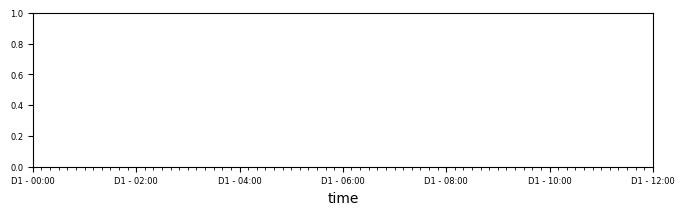

In [1]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTInput,getFrameInput


def frameToTimeTicker(x, pos):
   
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    
if __name__ == '__main__':
    
    print("Code launched.")
    #Choose the files to process
    files = getFilesToProcess()
    tmin = getFrameInput("Start")
    tmax = getFrameInput("End")

    nbTimeBins = int((tmax-tmin)/18000) #10min = 18000frames
    timebins = []
    
    print(f"There will be {nbTimeBins} bins of 10min (18000frames) in the graph")
    for i in range(nbTimeBins+1):
        timebins.append(i * 18000)
        
    print(f"The timebinList is: {timebins} \n")   
    print(f" with a length of {len(timebins)}.")
    
    """
    behavioralEvents = ["Contact", "Oral-oral Contact", "Oral-genital Contact", "Side by side Contact", 
                        "Side by side Contact, opposite way", "Social approach", "Get away", "Approach contact", 
                        "Approach rear", "Break contact", "FollowZone Isolated", "Train2", "Group2", "Group3", "Group4",
                        "Group 3 break", "Group 3 make", "Group 4 break", "Group 4 make", "Move isolated", 
                        "Move in contact", "Rear isolated", "Rear in contact", "Stop isolated", 
                        "WallJump","totalDistance", "Fight", "Won Fight", "Lost Fight", "SAP"]
    """
    behavioralEvents = ["totalDistance"]
    animalTotalDistance = {}
    animalDistancePerBin = {}
    listCumulated = {}
    listValue = {}
    
    # print(behavioralEvents)
    
    # behaviorToPlot = input("Which behavior do you want to plot the Cumulated graph? (No choice here... totalDistance) : ")
    
    behaviorToPlot = "totalDistance"
    
    print("\n This script will plot the totalDistance traveled by the mice in the selected database... \n")
    
    saveFile = f"figTimeLine-{behaviorToPlot}"

    for file in files:
        print(file)
        expName = file[-30:-7] #Select the name of XP in the filename
        print("expName is: ", expName )
        
        connection = sqlite3.connect( file )
    
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        """        
        pool.loadDetection( start = tmin, end = tmax, lightLoad=True)
        """
        
        #Load the timeline of the event over all individuals
        behaviorTimeLine = {}

        for animal in pool.animalDictionnary.keys():
            print( pool.animalDictionnary[animal].RFID )
            behaviorTimeLine[animal] = EventTimeLine( connection, behaviorToPlot, idA=animal, minFrame=tmin, maxFrame=tmax )
#             behaviorTimeLine[animal].removeEventsBelowLength( maxLen = MIN_WATER_STOP_DURATION )

            print("Computing the distance:")
            pool.animalDictionnary[animal].loadDetection( start=tmin, end=tmax, lightLoad = True )
            animalTotalDistance[animal] = pool.animalDictionnary[animal].getDistance(tmin,tmax)/100 # Total distance in meters (m)
            tenMinBin = 10*30*60 #Bins of 10 minutes = 18000 frames
            print("The time bin is 10min = 18 000 frames.")
            animalDistancePerBin[animal] = pool.animalDictionnary[animal].getDistancePerBin(binFrameSize = tenMinBin , minFrame=tmin, maxFrame=tmax ) # in centimeters (m)
            
            print("\n")
            print(f"The animalDistancePerBin for animal {animal} is:")
            print(animalDistancePerBin[animal])
            print(f"of lenght {len(animalDistancePerBin[animal])}.")
        
        # Build the plot
        fig, ax = plt.subplots(1,1 , figsize=(8, 2 ) )
        ax = plt.gca() # get current axis
        #ax.set_ylim([ymin, ymax])
        
        #set x axis
        ax.set_xlabel("time")
        ax.set_xlim([0, tmax])
        formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(labelsize=6 )
        ax.xaxis.set_major_locator(ticker.MultipleLocator( 18000 * 12 )) # 10min = 18000 frames
        ax.xaxis.set_minor_locator(ticker.MultipleLocator( 18000 ))
                
        # Draw the rectangles for the nights
#         print("loading night events for file " + file)
#         nightTimeLine = EventTimeLine( connection, "night" , minFrame=tmin, maxFrame=tmax )
        
#         for nightEvent in nightTimeLine.getEventList():
#             ax.axvspan( nightEvent.startFrame, nightEvent.endFrame, alpha=0.1, color='black')
#             ax.text( nightEvent.startFrame+(nightEvent.endFrame-nightEvent.startFrame)/2 , 200 , "dark phase" ,fontsize=6, ha='center')
        
        totalDistance = {}
        timeBin = 1
        
        #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
        legendHeight = 60
        rfids_legend = []
        geno_legend = []
        
        for animal in pool.animalDictionnary.keys():
            rfids_legend.append(pool.animalDictionnary[animal].RFID[4:])
            geno_legend.append(pool.animalDictionnary[animal].genotype)
            
            # if "Amphet" in pool.animalDictionnary[animal].genotype:
            #     color = "red"
            # else:
            #     color="blue" 
            # print ( pool.animalDictionnary[animal].RFID )
            
#             ax.text(30*60*60, legendHeight, "{} {}".format(pool.animalDictionnary[animal].RFID[5:], 
#                                                            pool.animalDictionnary[animal].genotype), color = color, fontsize=5)
            
# #                     color=getAnimalColor(animal), fontsize=5 )
#             legendHeight += 30 

        print("\n")
        print(f"RFID legends: {rfids_legend}")
        print(f"Geno legends: {geno_legend}")
             
        for animal in pool.animalDictionnary.keys():
            # print(f"\n Animal {animal}")
            # listCumulated = []
            # listValue = behaviorTimeLine[animal].getDurationEventInTimeBin( tmin=tmin, tmax=tmax, binSize=timeBin*oneMinute)
            
            listValue[animal] = animalDistancePerBin[animal]
            
            cumul = 0 # To compute the cumulative value of the event (totalDistance here)
            cumulList = []
            for value in listValue[animal]:
                cumul+= value
                # listCumulated[animal].append(cumul)
                cumulList.append(cumul)
                
            totalDistance[animal]= cumulList # totalDistance is a dict with 'animal number' as key and the list of cumulated Distance in values
        
            # print(f"\n Total distance : {totalDistance[animal]} for animal : {animal}.")
        
        print("\n nbtimebins: ", nbTimeBins)
        
        # abs = [1*oneMinute]
        # for t in range(1, nbTimeBins):
        #     x = abs[t-1] + timeBin*oneMinute
        #     abs.append(x)
        
        # Check if timebins and totalDistance have the same size :
        while len(timebins) > len(totalDistance[1]):
            timebins = timebins.pop()
            print("popped last timebin value")  
            
        for animal in totalDistance:
            if "Amphet" in pool.animalDictionnary[animal].genotype:  # AMPHET mice in RED
                color = "red"
            else:  # NACL mice in BLUE
                color="blue"
            # ax.plot( abs, totalDistance[animal] , color= color) # color= getAnimalColor( animal )
            
            ax.text(30*60*60, legendHeight, "{} {}".format(pool.animalDictionnary[animal].RFID[5:], 
                                                           pool.animalDictionnary[animal].genotype), color = color, fontsize=5)
            
#                     color=getAnimalColor(animal), fontsize=5 )
            legendHeight += 30 
    
            print(f"\n TotalDistance of animal {animal}: {totalDistance[animal]}")
            
            ax.plot(timebins, totalDistance[animal] , color= color) # color= getAnimalColor( animal )

                
        ax.legend(geno_legend) #ADD THE GENOTYPE AS LEGEND
        fig.suptitle(f"{expName} / {behaviorToPlot}")

        figName = f"FigCumul-{behaviorToPlot}_{expName}.png"
        print (behaviorToPlot)
        print(expName)
        print ("Saving figure... \n" , figName )
        fig.savefig( figName ,dpi=100)
        
        plt.show()
        plt.close( fig )
        
        connection.close() #Stop connection to the DBs
        
        print( "*** ALL JOBS DONE *** ")


In [11]:
behaviorDuration

{2: 15867.04411508765, 1: 18416.75509121774, 3: 12231.452091771182}

In [13]:
len(behaviorDuration[2])

72

In [9]:
for i in animalDistancePerBin:
    print(i)

1
2
3
